### Simulating transit light curves and parameter retrieval
- requisite modules: batman, numpy, matplotlib, lmfit

In [17]:
# Loading functions

In [18]:
import batman
import numpy as np
import matplotlib.pyplot as plt
from numpy import linspace, random
import lmfit

def residual_transitfit(params, x, data, eps_data, names):
    params_batman = set_params_batman(params, names)
    m = batman.TransitModel(params_batman, x)    #initializes model
    model = m.light_curve(params_batman)         #calculates light curve
    return (data-model) / eps_data

def model_transitfit_from_lmparams(params, x, names):
    params_batman = set_params_batman(params, names)
    m = batman.TransitModel(params_batman, x)    #initializes model
    model = m.light_curve(params_batman)         #calculates light curve
    return model


def q_to_u_limb(q_arr):
    q1 = q_arr[0]
    q2 = q_arr[1]
    u1 = np.sqrt(q1) * 2 * q2
    u2 = np.sqrt(q1) * (1- 2 * q2)
    return np.array([u1, u2])

def set_params_batman(params_lm, names, limb_type ="quadratic"):
    
    params = batman.TransitParams()       #object to store transit parameters
    params.limb_dark =  limb_type        #limb darkening model
    q_arr = np.zeros(2)
    for i in range(len(names)):
        value = params_lm[names[i]]
        name = names[i]
        if name=="t0":
            params.t0 = value
        if name=="per":
            params.per = value         
        if name=="rp":
            params.rp = value
        if name=="a":
            params.a = value
        if name=="inc":
            params.inc = value               
        if name=="ecc":
            params.ecc = value          
        if name=="w":
            params.w = value  
        if name=="q1":
            q_arr[0] = value
        if name=="q2":
            q_arr[1] = value
    
    u_arr = q_to_u_limb(q_arr)
    params.u = u_arr
    return params

def set_params_lm(names, values, mins, maxes, vary_flags):
    params = lmfit.Parameters()
    for i in range(len(names)):
        if vary_flags[i]:
            params.add(names[i], value=values[i], min=mins[i], max = maxes[i], vary = vary_flags[i])
        else:
            params.add(names[i], value=values[i], vary = vary_flags[i])
    return params

In [19]:
## Data making

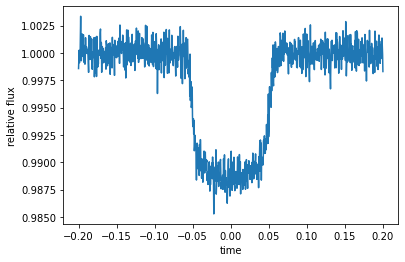

In [20]:
## Input parameters for transiting planet
## We consider HD209458b-like planet 
## http://exoplanet.eu/catalog/hd_209458_b/
params = batman.TransitParams()       #object to store transit parameters
params.t0 = 0.                        #time of inferior conjunction
params.per = 3.5                       #orbital period (in day)
params.rp = 0.1                       #planet radius (in units of stellar radii)
params.a = 10.                        #semi-major axis (in units of stellar radii)
params.inc = 88                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 90.                        #longitude of periastron (in degrees)

# Input limb darkening
params.limb_dark = "quadratic"        #limb darkening model
q_init = np.array([0.3,0.3])
u_init = q_to_u_limb(q_init)
params.u = q_to_u_limb(u_init)      #limb darkening coefficients [u1, u2]

# Data making
t = np.linspace(-0.2, 0.2, 1000)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model

flux_no_noise = m.light_curve(params)                    #calculates light curve
error_scale = 0.001
eps_data = random.normal(size=t.size, scale=error_scale)
flux = flux_no_noise + eps_data

plt.plot(t, flux)
plt.xlabel("time")
plt.ylabel("relative flux")
plt.show()

[[Variables]]
    t0:   0 (fixed)
    per:  3.5 (fixed)
    rp:   0.09641122 (init = 0.08)
    a:    10.3609134 (init = 8)
    inc:  90.0063407 (init = 83)
    ecc:  0 (fixed)
    w:    90 (fixed)
    q1:   1.00000000 (init = 0.2)
    q2:   0.01611872 (init = 0.2)


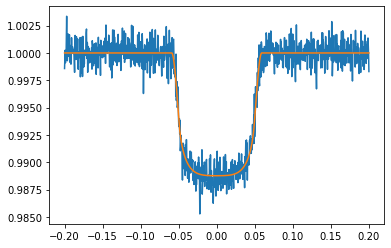

In [21]:
## from lmfit import minimize, Parameters

names = ["t0", "per", "rp", "a", "inc", "ecc", "w", "q1", "q2"]
values = [0, 3.5, 0.08, 8, 83, 0, 90, 0.2, 0.2]
mins = [0, 3.5, 0.03, 4, 80, 0, 90, 0.0, 0.0]
maxes = [0, 3.5, 0.2, 20, 110, 0, 90, 1.0, 1.0]
vary_flags = [False, False, True, True, True, False, False, True, True]
params = set_params_lm(names, values, mins, maxes, vary_flags)

out = lmfit.minimize(residual_transitfit, params, args=(t, flux, error_scale, names))
flux_model = model_transitfit_from_lmparams(out.params, t, names)
print(lmfit.fit_report(out.params))

plt.plot(t, flux)
plt.plot(t, flux_model)

